<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/4_Cluster_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster Interpreatation
## This notebook applies the finalized preprocessing and clustering configuration to assign customers to segments and interpret the resulting clusters.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

In [10]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [11]:
# Reusing spending variables identified during EDA
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

X = df[spend_cols]

In [12]:
X_log = np.log1p(X)

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X_log)

In [14]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

### K-Means with K=3 on 3 pca components


In [15]:
km = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init=10 to suppress future warnings
cluster_labels = km.fit_predict(X_pca)

df['Cluster'] = cluster_labels

## Silhouette Analysis (Visual Purpose)
Silhouette analysis is used here to visually validate cluster separation and confirm the selected number of clusters.

For n_clusters = 2, The average silhouette_score is: 0.356
For n_clusters = 3, The average silhouette_score is: 0.331
For n_clusters = 4, The average silhouette_score is: 0.255
For n_clusters = 5, The average silhouette_score is: 0.277
For n_clusters = 6, The average silhouette_score is: 0.286
For n_clusters = 7, The average silhouette_score is: 0.278
For n_clusters = 8, The average silhouette_score is: 0.282


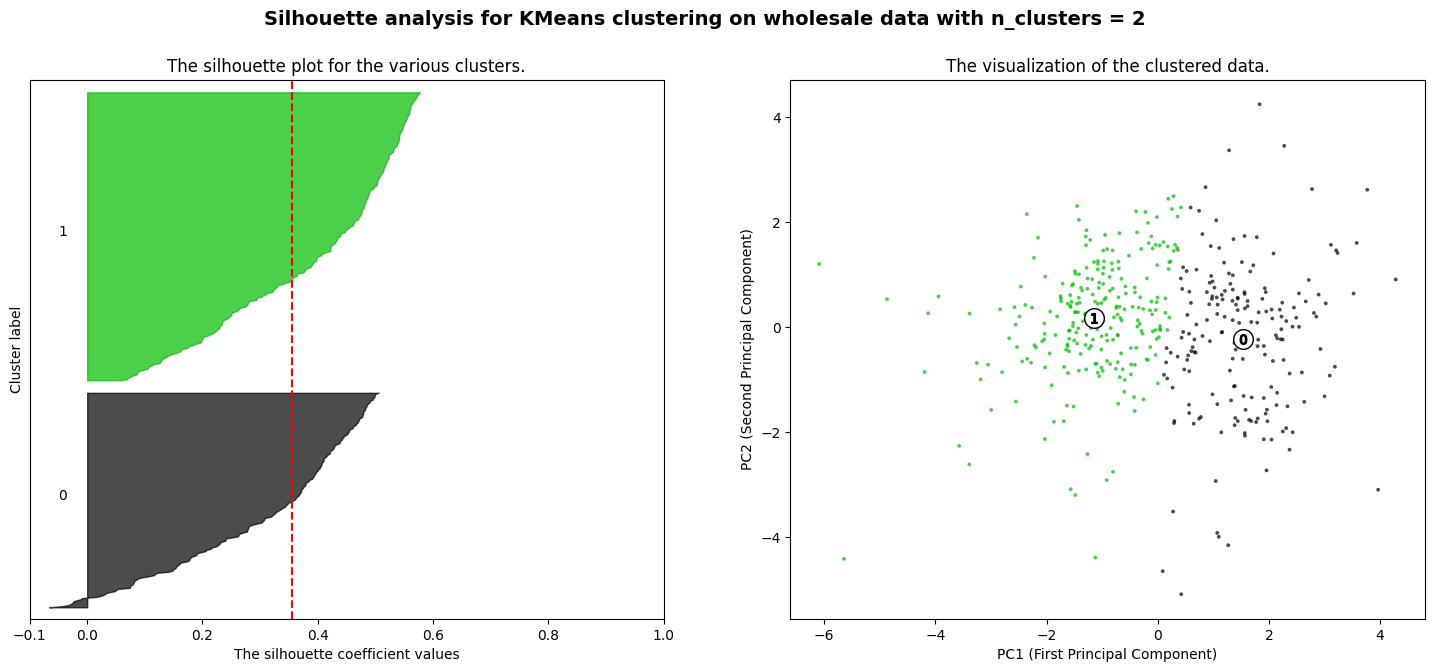

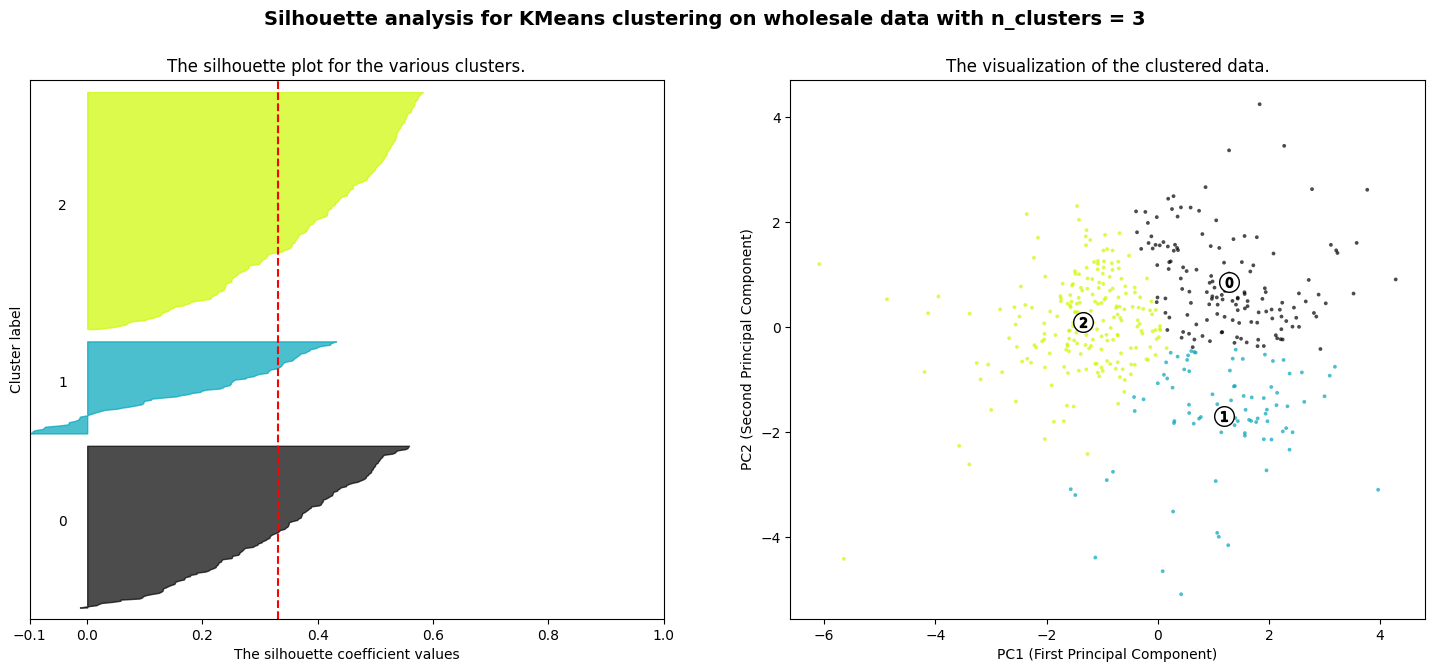

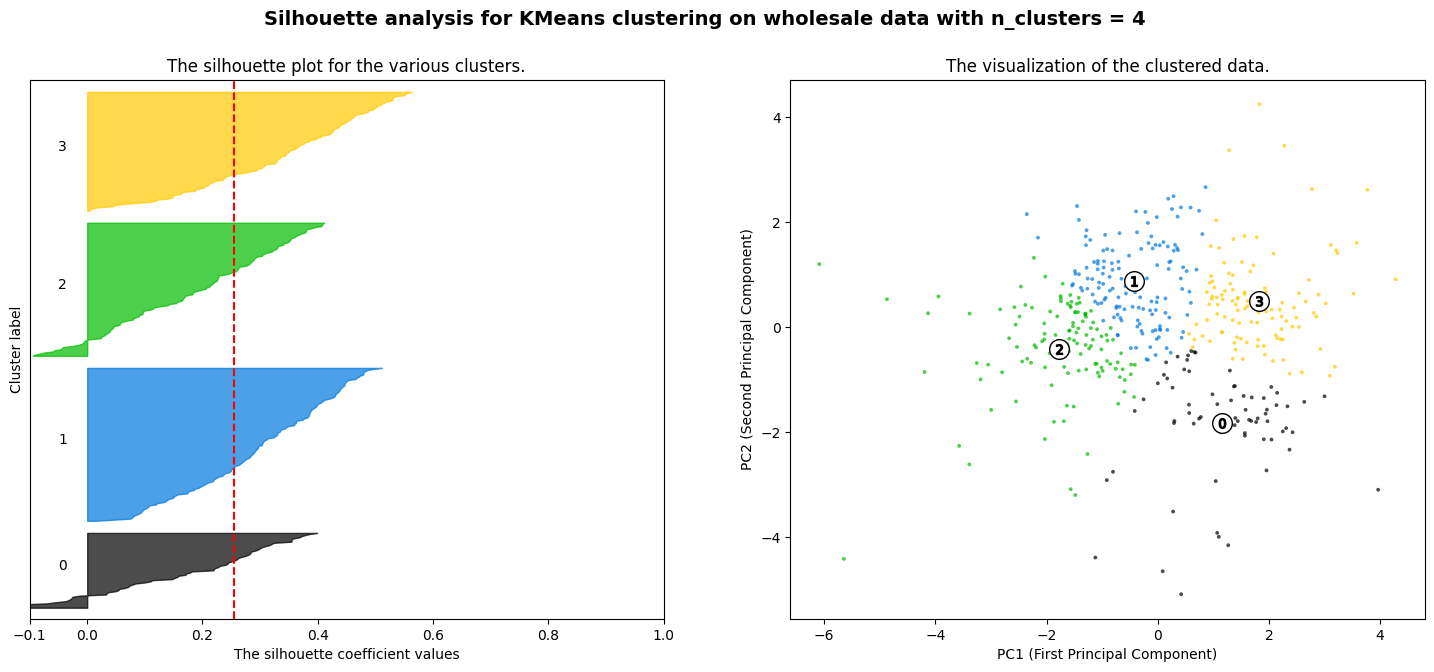

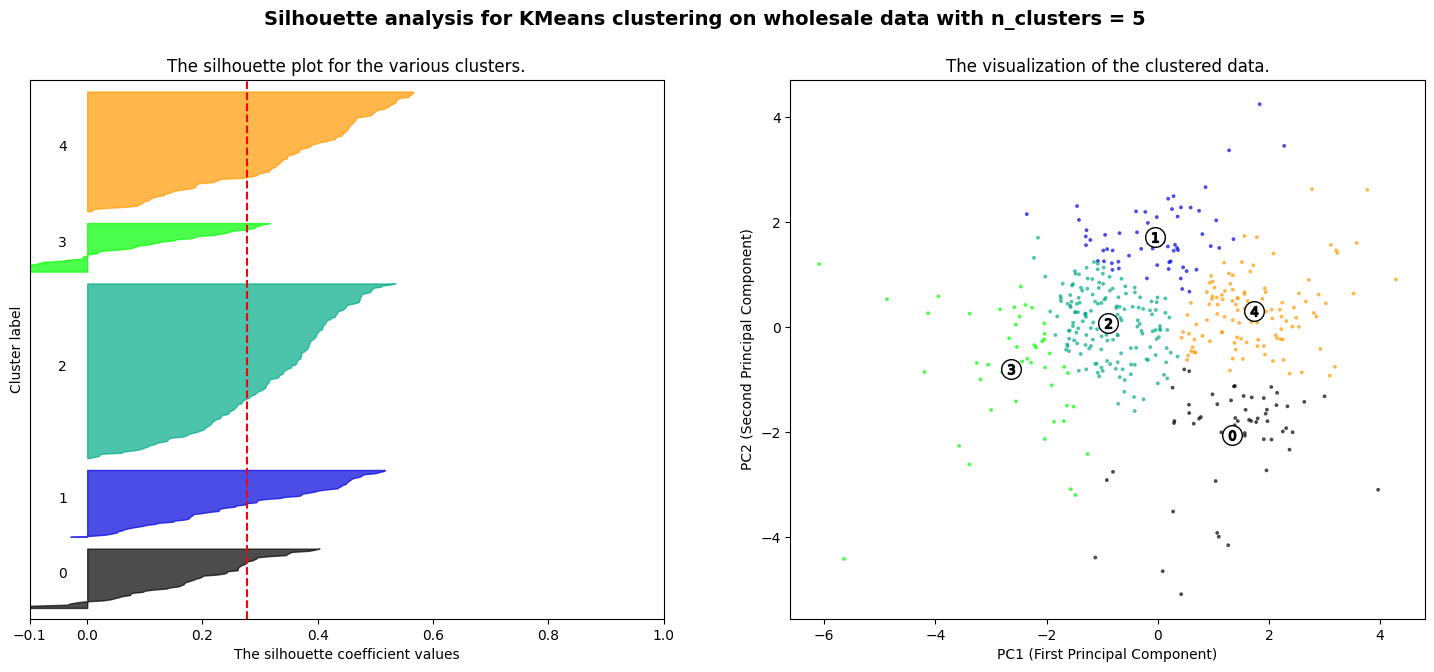

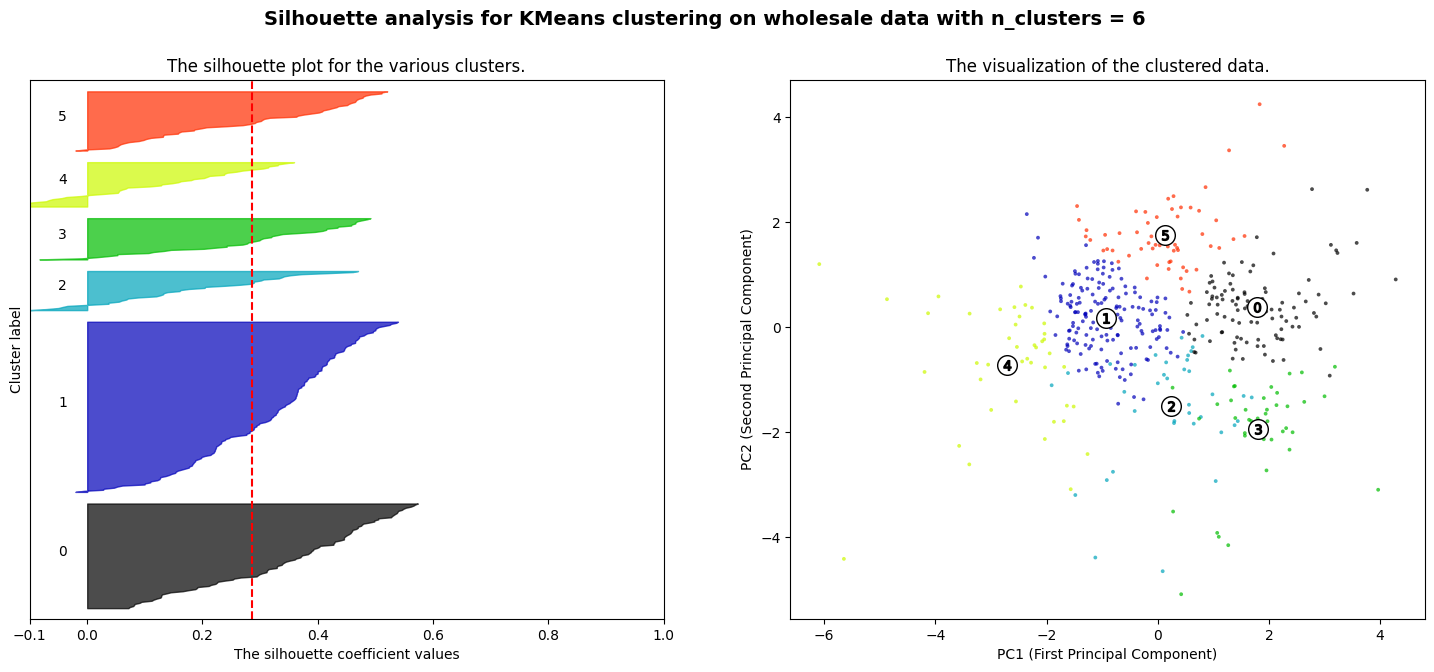

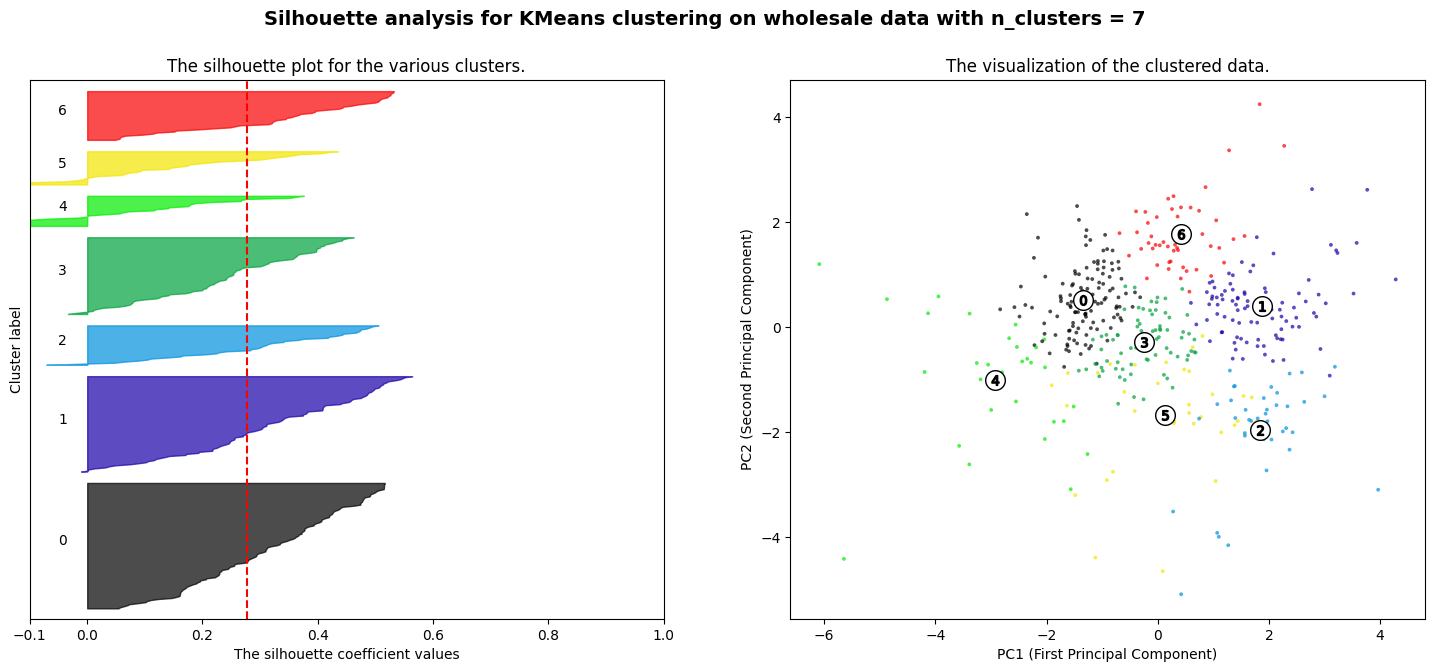

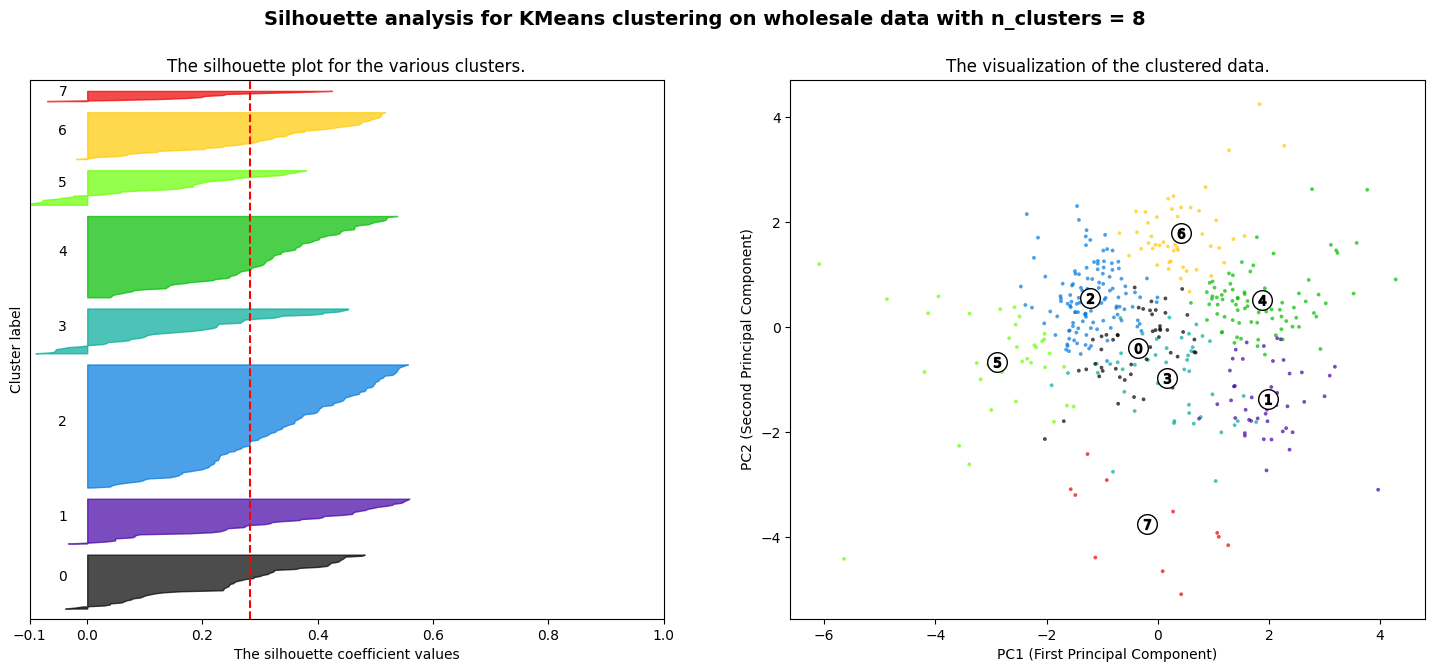

In [16]:
import matplotlib.cm as cm

# Use the X-pca from the PCA transformation
# X_pca = pca.fit_transform(X_scaled)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        f"For n_clusters = {n_clusters}, "
        f"The average silhouette_score is: {silhouette_avg:.3f}"
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)



    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed (using PC1 and PC2)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1],
        marker=".", s=30, lw=0, alpha=0.7,
        c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1 (First Principal Component)")
    ax2.set_ylabel("PC2 (Second Principal Component)")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on wholesale data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


* Silhouette analysis is shown across multiple values of k (2–8) to illustrate the trade-off between statistical separation and business interpretability.

* While k = 2 produces the highest average silhouette score, it results in overly broad clusters that does not produce meanings.

* Both k = 3 and k = 4 appear plausible; however, k = 3 has a higher silhouette score and maintains moderate separation while improving interpretability.

* Therefore, k = 3 is validated to be be the optimal clustering solution.

## Cluster Profiling
### Clusters are referenced using descriptive segment names based on dominant spending patterns; detailed interpretations are provided below.

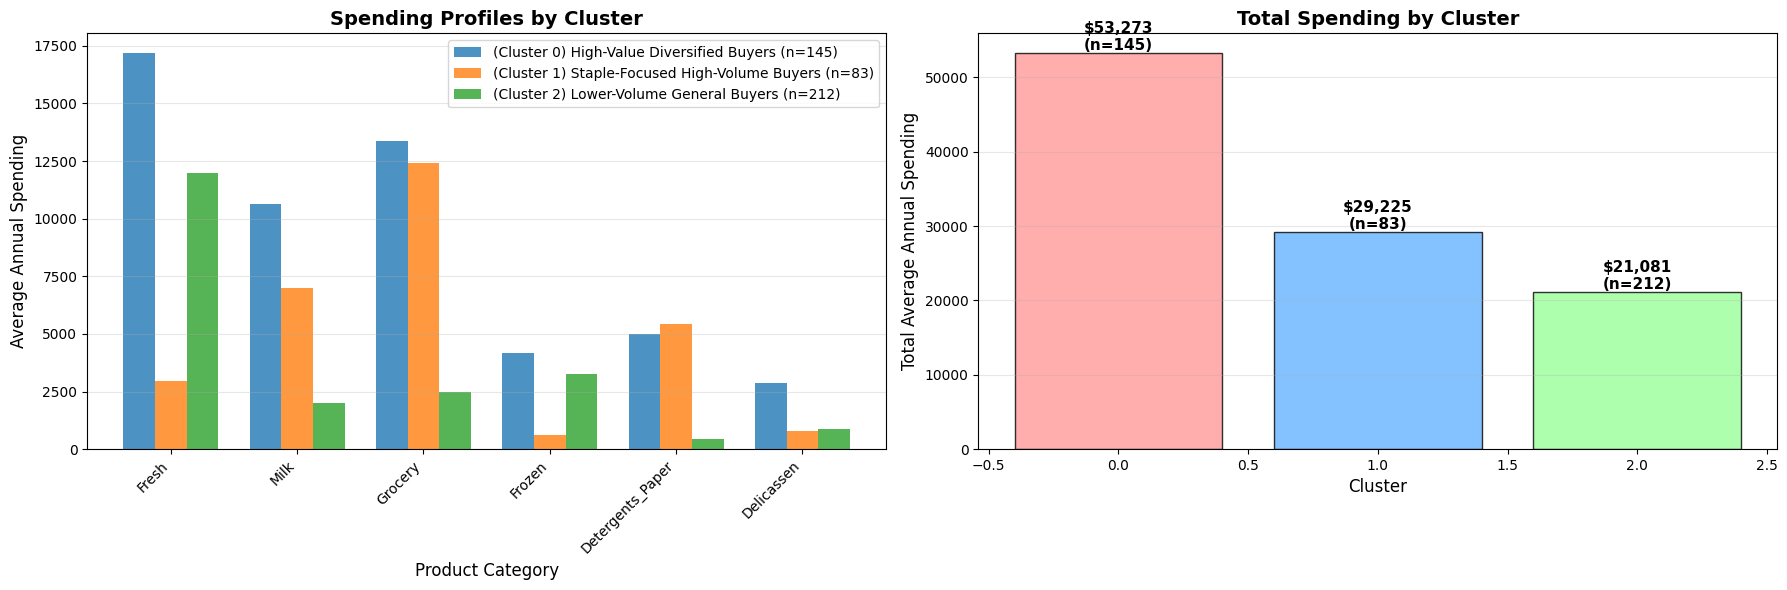


=== CLUSTER INTERPRETATION ===

Cluster 0 (145 customers, 33.0%):
  Total avg spending: $53,273
  Top 3 categories: Fresh, Grocery, Milk

Cluster 1 (83 customers, 18.9%):
  Total avg spending: $29,225
  Top 3 categories: Grocery, Milk, Detergents_Paper

Cluster 2 (212 customers, 48.2%):
  Total avg spending: $21,081
  Top 3 categories: Fresh, Frozen, Grocery


In [68]:
import matplotlib.pyplot as plt
import numpy as np

cluster_names = {
    0: 'High-Value Diversified Buyers',
    1: 'Staple-Focused High-Volume Buyers',
    2: 'Lower-Volume General Buyers'
}

# Calculate averages
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_sizes = df['Cluster'].value_counts().sort_index()

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Left: Spending by category
x = np.arange(len(spend_cols))
width = 0.25

for i, cluster in enumerate(cluster_summary.index):
    offset = width * (i - 1)
    ax1.bar(x + offset, cluster_summary.loc[cluster], width,
            label=f'(Cluster {cluster}) {cluster_names[cluster]} (n={cluster_sizes[cluster]})', alpha=0.8)

ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Average Annual Spending', fontsize=12)
ax1.set_title('Spending Profiles by Cluster', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(spend_cols, rotation=45, ha='right')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')



# Right: Total spending comparison
totals = cluster_summary.sum(axis=1)
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars = ax2.bar(cluster_summary.index, totals, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, size in zip(bars, cluster_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}\n(n={size})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Total Average Annual Spending', fontsize=12)
ax2.set_title('Total Spending by Cluster', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print clear interpretation
print("\n=== CLUSTER INTERPRETATION ===")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    avg_spend = cluster_data[spend_cols].mean()

    print(f"\nCluster {cluster} ({len(cluster_data)} customers, {len(cluster_data)/len(df)*100:.1f}%):")
    print(f"  Total avg spending: ${avg_spend.sum():,.0f}")
    print(f"  Top 3 categories: {', '.join(avg_spend.nlargest(3).index.tolist())}")

### Table 1. Average Spending by Product Category per Cluster

In [48]:
cluster_names = {
    0: 'High-Value Diversified',
    1: 'Staple-Focused High-Volume',
    2: 'Lower-Volume General'
}

cluster_means = (
    df
    .groupby('Cluster')[spend_cols]
    .mean()
    .round(2)
)

cluster_means.insert(
    0,
    'Cluster Name',
    cluster_means.index.map(cluster_names)
)

cluster_means


,Cluster Name,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,,
0,High-Value Diversified,17182.39,10658.08,13380.98,4181.11,5003.64,2867.22
1,Staple-Focused High-Volume,2966.93,7010.90,12397.28,608.28,5446.23,795.00
2,Lower-Volume General,11992.59,1995.43,2496.92,3277.84,425.91,892.50


## Table 2. Customer Segment Summary

In [60]:
cluster_size = df['Cluster'].value_counts().sort_index()

cluster_pct = (cluster_size / len(df) * 100).round(1)

summary = pd.DataFrame({
    # 'Cluster': cluster_means.index,
    'Cluster Name': cluster_means.index.map(cluster_names),
    'Cluster Size': cluster_size.values,
    'Cluster %': cluster_pct.values,
    'Total Avg Spending': cluster_means[spend_cols].sum(axis=1).round(0),
    'Top Category': cluster_means[spend_cols].idxmax(axis=1),
    'Lowest Category': cluster_means[spend_cols].idxmin(axis=1)
})

summary.reset_index().rename(columns={'index': 'Cluster'})
summary


,Cluster Name,Cluster Size,Cluster %,Total Avg Spending,Top Category,Lowest Category
Cluster,,,,,,
0,High-Value Diversified,145,33.0,53273.0,Fresh,Delicassen
1,Staple-Focused High-Volume,83,18.9,29225.0,Grocery,Frozen
2,Lower-Volume General,212,48.2,21081.0,Fresh,Detergents_Paper


## Cluster Interpretation:

####  **Custer 0 (High-Value Diversified Buyers):**

Cluster 0 represents the **highest-spending customers across most product categories**, with the exception of Detergent-Paper.
* This group exhibits high spending levels and a broad purchasing profile, indicating large-volume buyers with diverse needs.
* These are customers that likely account for a substantial share of the store's revenue and represent strategically important accounts due to their high purchasing volume and category coverage.

#### **Cluster 1 (Staple-Focused High-Volume Buyers):**

Cluster 1 represents the smallest cluster volume of customers.

* Customers in this segment spend disproportionately high amounts on staple goods such as **Grocery, Milk, and Detergents-Paper**, indicating a focus on essential household or operational supplies rather than fresh or specialty products.

* This pattern suggests consistent, necessity-driven purchasing behavior rather than broad or diversified consumption.

#### **Cluster 2 (Lower-Volume General Buyers):**

Cluster 2 contains the largest number of customers with a lower average spending across all product categories.
* This pattern suggests smaller-scale or infrequent buyers with limited purchasing volume.
* These customers may engage in **more selective or occasional purchasing** rather than bulk or high-volume transactions.





 ## Business Implications


#### **Cluster 0 (High-Value Diversified Buyers)** - Highest overall spend across categories

This segment represents the most valuable customers with diversified purchasing behavior.

Actionable strategies:

* Prioritize account management and retention programs.

* Provide exclusive promotions, early access, or loyalty incentives.

* Provide credit or debit cards for cashback discounts.

* Offer cross-category promotions (e.g., Fresh + Frozen + Grocery).

* Use this segment for new product trials or premium offerings due to higher engagement.

#### **Cluster 1 (Staple-Focused High-Volume Buyers)** - High Grocery, Milk, Detergents_Paper

These customers prioritize essential household and operational supplies.

Actionable strategies:

* Offer bundle discounts on products (e.g., Grocery + Detergents_Paper).

* Distribute or email recurring coupons for consumables to encourage repeat purchasing.

* Introduce auto-replenishment or subscription-style offers for high-frequency items.

* In wholesale contexts, target this segment with volume-based pricing or contract pricing.



#### **Cluster 2 (Lower-Volume General Buyers):** - Lower spend, concentrated categories

These customers purchase selectively and represent growth potential.

Actionable strategies:

* Use targeted discounts to encourage category expansion.

* Promote sampling programs (e.g., in-store food samples or trial-sized products).

* Run entry-level bundle promotions to increase basket size.

* Focus on seasonal or promotional campaigns rather than everyday discounts.

# Summary and Opportunities for Further Analysis

This analysis segments customers based solely on aggregated spending behavior across product categories. While the resulting clusters reveal meaningful purchasing patterns, additional data could significantly enhance segmentation quality and business insight.

Future improvements could include:

* Time-series purchasing data to capture seasonality, frequency, and customer lifecycle behavior.

* Transaction-level data to distinguish bulk purchases from frequent small orders.

* Demographic or firmographic attributes (e.g., business size, customer type, location density).

* Channel interaction data to assess differences in purchasing behavior across sales channels.

*Promotional response history to measure price sensitivity and campaign effectiveness.

Incorporating these features would enable more precise segmentation, improved personalization, and stronger predictive modeling for customer behavior.